# **CS4187 - Assignment 2**

## **Students**

Boris Bobylkov - *21317097*

Italo Terto da Silva - *21326312*

Code compiles with no errors.

Resourses:
*  https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
*  https://keras.io/api/applications/inceptionv3/
*  https://keras.io/api/applications/vgg/
*  https://matplotlib.org/stable/users/explain/axes/index.html
*  https://matplotlib.org/stable/users/explain/colors/colormaps.html
*  https://seaborn.pydata.org/generated/seaborn.heatmap.html
*  sample assignment 1: https://learn.ul.ie/d2l/le/lessons/45660/topics/815708
*  https://www.tensorflow.org/api_docs/python/tf/image
*  https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html


## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import h5py
from sklearn.model_selection import KFold as KFold
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import InputLayer, Conv2D, Conv3D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Concatenate, Input, GlobalAveragePooling2D, RandomRotation
from tensorflow.keras.models import Model
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

print("All imported correctley")

All imported correctley


 ## Hyperparameters

INPUT_SHAPE: The shape of the data that will be provided to the model.  

NUM_CLASSES: The amount of outputs.

KFOLD_SPLIT: The number of splits for the K-Fold Cross Validation.

KFOLD_SPLIT_VGG19: The number of splits for the VGG19 K-Fold Cross Validation.

BATCH_SIZE: Sample sizes used to train the model per epoch.

BATCH_SIZE_VGG19: Sample sizes used to train the VGG19 per epoch.

EPOCHS: The number of training iterations the model will go through the dataset. This affects how much the model learns.

LOSS: The loss function that is used to calculate the error of the model.

LEARNING_RATE: The rate in which the optimiser learns.

OPTIMIZER: The neural algorithm that will be used for training.

In [ ]:
# Hyperparameters
INPUT_SHAPE = (75, 75, 3)
NUM_CLASSES = 10

KFOLD_SPLIT = 5
KEFOLD_SPLIT_VGG19 = 10
BATCH_SIZE = 128
BATCH_SIZE_VGG19 = 64
EPOCHS = 10

LOSS = 'categorical_crossentropy'
LEARNING_RATE = 0.001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

print("Hyperparameters set")

Hyperparameters set


Reason why we decided to go with Adam optimzer is because it will provide better hendling of CNN chalages, like parametr update.

## **1. Dataset** <a class="anchor" id="dataset"></a>

For this assignment we will be using the CIFAR-10 dataset, which consists of 60 thousands of images, 32x32 pixels in size, that can be categorised/classified into 10 classes. The dataset is split in to 50 thousands images for training and 10 thousands images for validation and classes that it would be categorised is Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

### Data augmentation reasoning
Main reason for data augmentation in this assignment is to rescale images to right size (75\*75, because this is the smallest size of input that pretraind inception v3 can handle), this would come with down side of loosing image details. To overcome this training dataset will undergo full augmentation that includes:

- Image resizing
- Random horizontal flip
- Random brightness adjustment
- Random contrast adjustment
- Random saturation adjustment
- Random rotation

Validation datasets will only undergo image resizing.

Resources:

* https://www.tensorflow.org/api_docs/python/tf/image
* https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

In [ ]:
#Perform data augmentation on individual image
def image_aug(img):
    #Resize
    image = tf.image.resize(img, (75, 75))

    # Random flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation adjustment
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Random rotation
    image = RandomRotation(factor=0.2)(image)

    return image

#This function perform only resize of the image, this will be used for validation and train dataset
def image_resize(img):
    image = tf.image.resize(img, (75, 75))
    return image

#This function will perform augmentation on the whole data set
def augment_dataset(dataset, full_augmentation):
    dataset = tf.convert_to_tensor(dataset)
    if full_augmentation:
        augmented_dataset = tf.map_fn(image_aug, dataset, dtype=tf.float32)
        return augmented_dataset
    else:
        augmented_dataset = tf.map_fn(image_resize, dataset, dtype=tf.float32)
        return augmented_dataset

print("Data augmentation functions added")

Data augmentation functions added


In [ ]:
# Input Dataset

# Here we are loading the CIFAR-10 dataset from the keras library
# and we are also making the target values for training and testing to categorical.

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize images to the range [0, 1]
#We are doing this so that model would be able to work with the values of each layer
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#Categorise labels for the dataset
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Data before augmentation")
dataType = x_train.shape
print(f"Data type: {dataType}")
labelType = y_test.shape
print(f"Data type: {labelType}")

#Augment the datasets for testing and traing
x_train = augment_dataset(x_train, True).numpy()
x_test = augment_dataset(x_test, False).numpy()

#Check that the shape after data augmentaion is correct
print("Data after augmentation")
dataType = x_train.shape
print(f"Data type: {dataType}")
labelType = y_test.shape
print(f"Data type: {labelType}")

Data before augmentation
Data type: (50000, 32, 32, 3)
Data type: (10000, 10)
Data after augmentation
Data type: (50000, 75, 75, 3)
Data type: (10000, 10)


### Dataset Visualisation

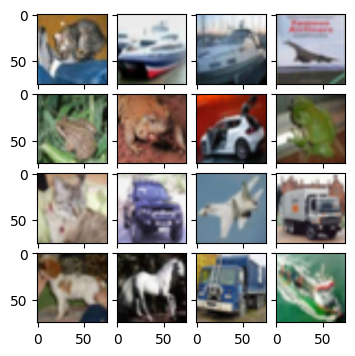

In [ ]:
#In this block we will display images from validation dataset that weren't augmented

#This code was addapted form the first assignment
im_list = []  # Empty list to store sample images.
n_samples_to_show = 16  # Number of images to display (4x4 grid)
for i in range(n_samples_to_show):
    im_list.append(x_test[i])  # This appends the first 16 used to visually confirm data.

# Visualization
# Setting up 4x4 grid to visualize images.
fig = plt.figure(figsize=(4, 4))  # setting figure size.

# Reference: https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html

grid = ImageGrid(fig, 111,  # similar to subplot(111), used ImageGrid for custom layout.
                 nrows_ncols=(4, 4),  # 4row x 4col grid
                 axes_pad=0.1,  # padding between grid.
                 )

# Display image grid.
for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)  #show each image in grayscale
plt.show()  # Show entire grid.

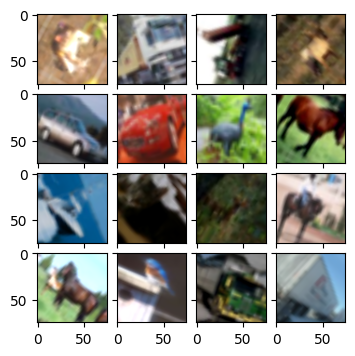

In [ ]:
#In this block we will display images from training dataset that were augmented

#This code was adapted form the first assignment
im_list = []  # Empty list to store sample images.
n_samples_to_show = 16  # Number of images to display (4x4 grid)
for i in range(n_samples_to_show):
    im_list.append(x_train[i])  # This appends the first 16 used to visually confirm data.

# Visualization
# Setting up 4x4 grid to visualize images.
fig = plt.figure(figsize=(4, 4))  # setting figure size.

# Reference: https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html

grid = ImageGrid(fig, 111,  # similar to subplot(111), used ImageGrid for custom layout.
                 nrows_ncols=(4, 4),  # 4row x 4col grid
                 axes_pad=0.1,  # padding between grid.
                 )

# Display image grid.
for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)  #show each image in grayscale
plt.show()  # Show entire grid.

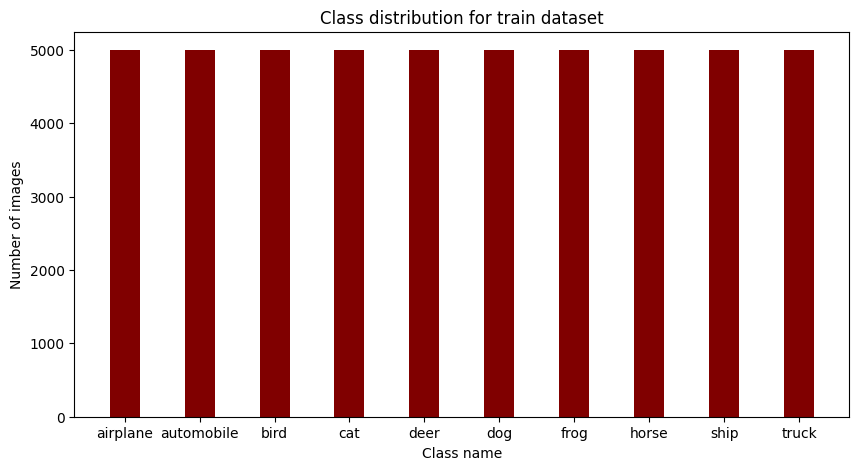

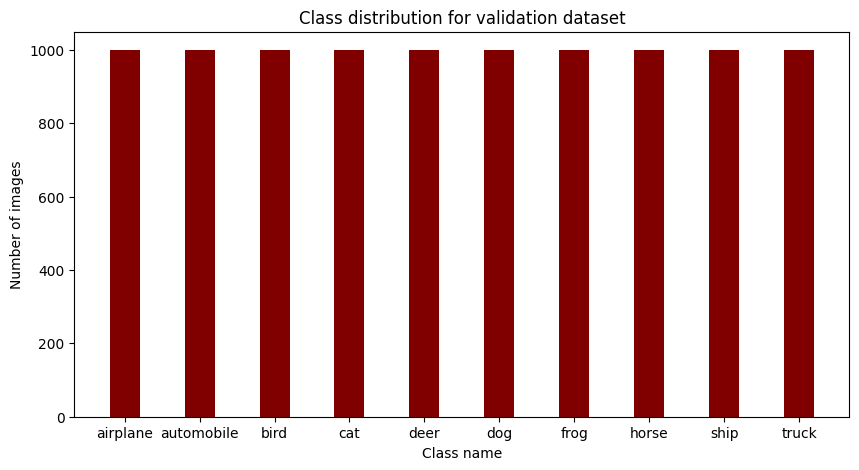

In [ ]:
#In this block we will display class distribution for training and validation dataset

#Initiate list for both datasets
all_values = [[],[]]
#List with class names
names = list(['airplane', 'automobile',  'bird',  'cat',  'deer',  'dog',  'frog',  'horse',  'ship',  'truck'])

#Sort values of traing dataset
values = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
for i in y_train:
    index = np.argmax(i)
    values[index] += 1

#Populate list with resulting values
for i in values.keys():
  all_values[0].append(values.get(i))

#Clear the list for next sort
values = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

#Sort valuse of validation datasets in the same way as for testing
for i in y_test:
    index = np.argmax(i)
    values[index] += 1

for i in values:
  all_values[1].append(values.get(i))

# creating the bar plot
plt.figure(figsize = (10, 5))
plt.bar(names, all_values[0], color ='maroon', width = 0.4)
plt.xlabel("Class name")
plt.ylabel("Number of images")
plt.title("Class distribution for train dataset")
plt.show()

plt.figure(figsize = (10, 5))
plt.bar(names, all_values[1], color ='maroon', width = 0.4)
plt.xlabel("Class name")
plt.ylabel("Number of images")
plt.title("Class distribution for validation dataset")
plt.show()

In [ ]:
def plot_acuracy_and_loss(import_history):
  # Code adapted from first assigment.
  all_train_accuracies = []
  all_val_accuracies = []
  all_train_losses = []
  all_val_losses = []

  # Iterate through all fold histories to accumulate the metrics
  for history in import_history:
      all_train_accuracies.extend(history['accuracy'])
      all_val_accuracies.extend(history['val_accuracy'])
      all_train_losses.extend(history['loss'])
      all_val_losses.extend(history['val_loss'])

  # Create plots for accuracy and loss
  plt.figure(figsize=(14, 6))

  # Plotting accuracy & Plotting Loss
  plt.subplot(1, 2, 1)
  plt.plot(all_train_accuracies, label='Training Accuracy')
  plt.plot(all_val_accuracies, label='Validation Accuracy', linestyle='dashed')
  plt.title('Accuracy over Folds \n (Spikes in validation accuracy \n are due to the problems with tensorflow)')
  plt.xlabel('Epochs (across folds)')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()

  plt.subplot(1, 2, 2)
#Next line is needed to be added so that loss graph would be readable is some cases
  plt.ylim([0, 1.5])
  plt.plot(all_train_losses, label='Training Loss')
  plt.plot(all_val_losses, label='Validation Loss', linestyle='dashed')
  plt.title('Loss over Folds \n (Spikes in validation loss that are going of the graph \n are due to the problems with tensorflow)')
  plt.xlabel('Epochs (across folds)')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(import_model):
  # Code adapted from Assignment 1.
  # Get predictions for the Test set
  y_pred = import_model.predict(x_test)

  # Convert predictions and test labels from one-hot encoding back to label format
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true_classes = np.argmax(y_test, axis=1)

  # Graph labels
  bars = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
  y_pos = np.arange(len(bars))

  # Calculating the confusion matrix
  cm = confusion_matrix(y_true_classes, y_pred_classes)

  # Create a heatmap for the confusion matrix
  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='jet', cbar=True, linewidths=0.5, square=True)

  # Plot the confusion matrix
  plt.title('Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
  plt.xlabel('Predicted', fontsize=14, labelpad=10)
  plt.ylabel('Actual', fontsize=14, labelpad=10)
  plt.xticks(ticks=np.arange(len(bars)) + 0.5, labels=bars, fontsize=12, rotation=45, ha='right')
  plt.yticks(ticks=np.arange(len(bars)) + 0.5, labels=bars, fontsize=12, rotation=0)
  plt.tight_layout()
  plt.show()

print("Graphs functions added")

Graphs functions added


## **2. The Network Structure**

The CNNs we decided to compare are the VGG 19 and Inception v3. The main goal of this is to compare how the different CNN models would perform using the same dataset and see how newer version of GoogleLeNet (Inception v1) would compare to the VGG19

### **VGG19**

VGG was introduced in 2014 in ILSVRC and was able to be a top ranking models, such as GoogleLeNet, and it was able to win in Classification+localization[1]. It had presented 4 models, containing VGG11, VGG13, VGG16 and VGG19.

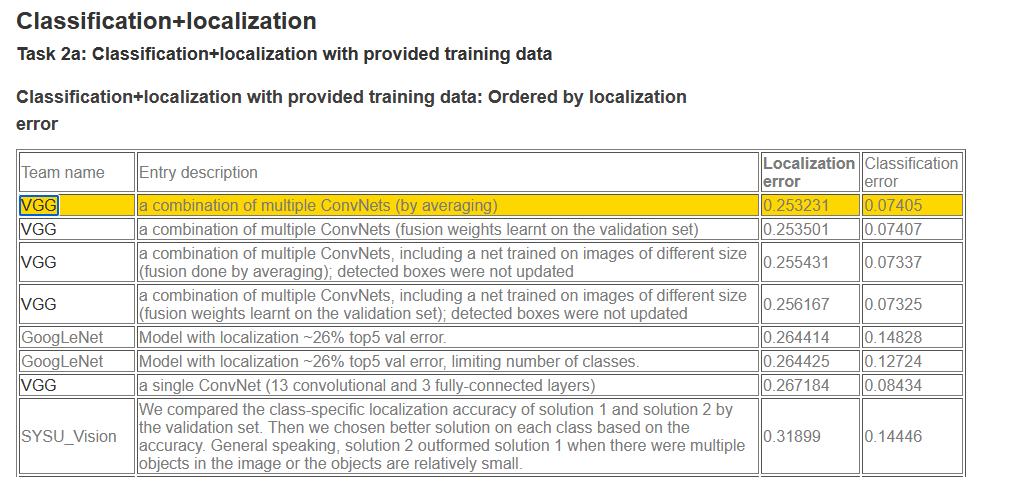
***Fig.1 Results of ILSVRC 2014 in Task 2a***

Models were developed in University of Oxford by Karen Simonyan, Andrew Zisserman. They described the architecture of the models in the paper *"VERY DEEP CONVOLUTIONAL NETWORKS
FOR LARGE-SCALE IMAGE RECOGNITION"* [2].

#### Architecture of VGG
The architecture of VGG is based on the convolutional levels and for this assignment we will use VGG19. VGG19 has its name because it has 19 convolutional layers split into 5 blocks. The architecture of this model in its original form contains an input layer of size 224\*224\*3 (RGB images of the size 224 by 224). After this input is taken, it goes through two 3×3 convolutional leyers with 64 channels, followed by a maxpooling layer. This repeats for 4 more times, with adjustment in number of channels 64 -> 128 -> 256 -> 512 and after the second block, the number of convolutional layers increase to 4 layers. After the convolutional layers are done it has two fully connected layers with 4096 size and finishes with a soft-max layer of size 1000 (because it was trained for ImageNet which has 1000 classes). The structure of other models, as well as VGG19, is demonstrated in fig. 2.

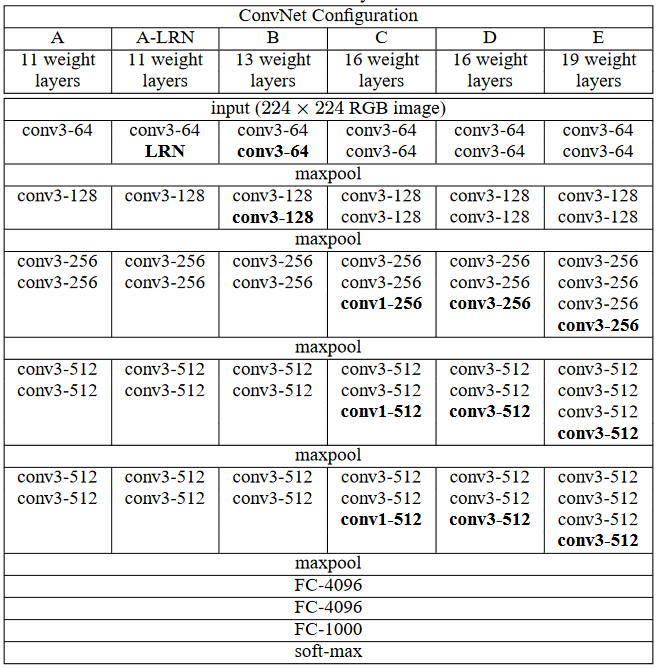
***Fig 2. Archetecture of VGG models***

For this assignment we will use pretrained models. Model for VGG 19 is utilised form Keras applications[3]

[1]https://www.image-net.org/challenges/LSVRC/2014/results.php

[2]https://arxiv.org/abs/1409.1556

[3]Pre-Trained model: https://keras.io/api/applications/vgg/

#### Frozen VGG 19

In this block we will look at performance of VGG19 with it default waits with out the traing.

In [ ]:
#Importing VGG from keras.applications
vgg = VGG19(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
NEW_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#Frizing layers so that they won't gonna train
for layer in vgg.layers:
  layer.trainable = False

#Flattens result of the imported VGG model
x = Flatten()(vgg.output)
#Sort resulting valuse into NUM_CLASSES, for dataset that we are using it is 10
prediction = Dense(NUM_CLASSES, activation='softmax')(x)

#Bulding the model
model_vgg = Model(inputs=vgg.input, outputs=prediction)

#Prints the sammary of the model
model_vgg.summary()

# compiling the sequential model
model_vgg.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=NEW_OPTIMIZER)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 75, 75, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,044,874 (76.47 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

####K fold

In [ ]:
skf = KFold(n_splits=KEFOLD_SPLIT_VGG19)
all_histories = []
kFoldIndex = 1

for train_index, val_index in skf.split(x_train):
    print(f"Current KFold {kFoldIndex}")
    kFoldIndex += 1
    # Split the datasets for this fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train model for this fold
    history = model_vgg.fit(x_train_fold, y_train_fold, batch_size=BATCH_SIZE_VGG19, epochs=EPOCHS, validation_data=(x_val_fold, y_val_fold))
    #Saves the history so that it would be possible to display it
    all_histories.append(history.history)

    # Evaluate the model
    val_loss, val_acc = model_vgg.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for this fold: {val_acc * 100:.2f}%")

Current KFold 1
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3642 - loss: 1.8162 - val_accuracy: 0.4976 - val_loss: 1.4731
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5029 - loss: 1.4362 - val_accuracy: 0.5202 - val_loss: 1.3959
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5328 - loss: 1.3563 - val_accuracy: 0.5252 - val_loss: 1.3709
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5576 - loss: 1.2976 - val_accuracy: 0.5428 - val_loss: 1.3454
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5609 - loss: 1.2759 - val_accuracy: 0.5234 - val_loss: 1.3602
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5664 - loss: 1.2514 - val_accuracy: 0.5514 - val_loss: 1.3186
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5741 - loss: 1.2372 - val_accuracy: 0.5608 - val_loss: 1.3079
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5842 - loss: 1.2176 -

##### Results
In this block we will display result of the fit of frozen VGG19 modle

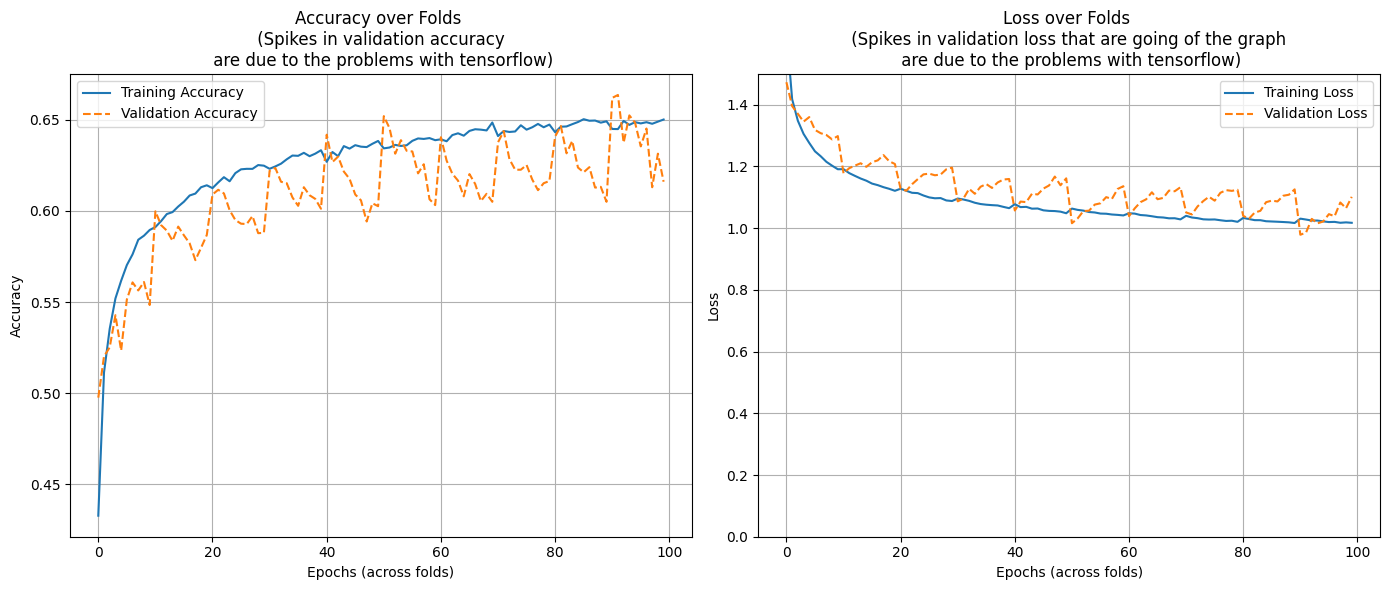

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


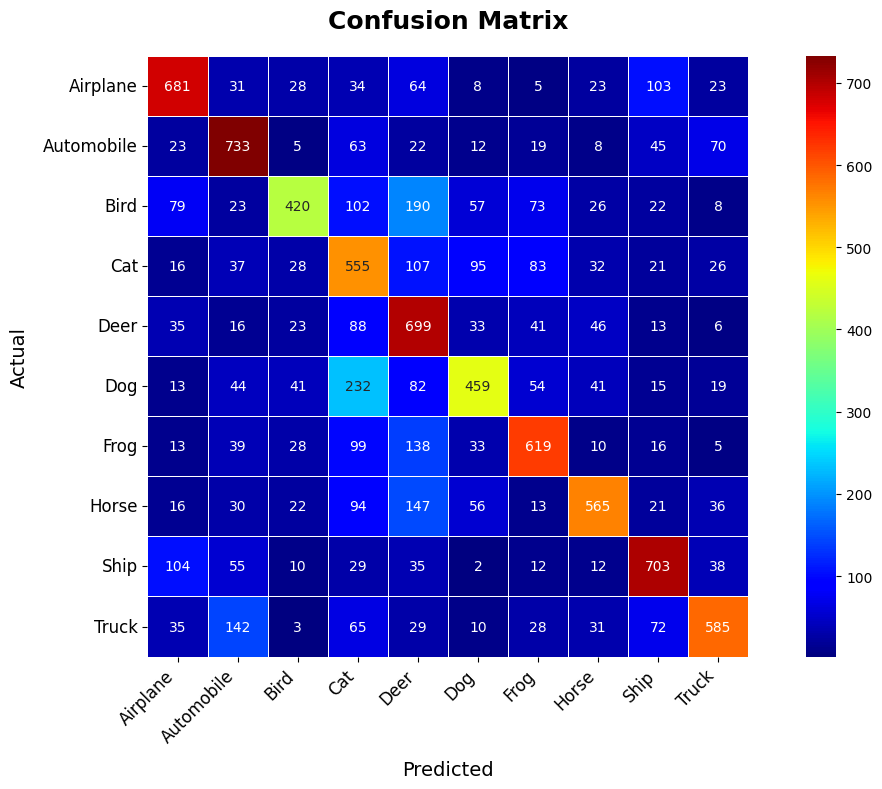

In [ ]:
# Accuracy and Loss over Folds
plot_acuracy_and_loss(all_histories)

# Confusion Matrix
plot_confusion_matrix(model_vgg)

#### Unfrozen VGG 19
In this block we will compile unfrozen model so that it would be able to adjust its weights which will result in a better acuracy and smoller loss

In [ ]:
## Download pre trained
vgg = VGG19(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

x = Flatten()(vgg.output)
prediction = Dense(NUM_CLASSES, activation='softmax')(x)

model_vgg = Model(inputs=vgg.input, outputs=prediction)

model_vgg.summary()

# compiling the sequential model
# for this one we used default optimizer because it gave better results
model_vgg.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 75, 75, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 75, 75, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,044,874 (76.47 MB)

 Trainable params: 20,044,874 (76.47 MB)

 Non-trainable params: 0 (0.00 B)

##### K fold
This model will be traind with K fold to maximise performance and make sure that the model wouldn't be overfited to the traing dataset.

(For better perfomance differen version of the Cross validation can be used, such as stratified k fold. That would have better distribution of classes across folds)

In [ ]:
skf = KFold(n_splits=7)
all_histories = []
kFoldIndex = 1

for train_index, val_index in skf.split(x_train):
    print(f"Current KFold {kFoldIndex}")
    kFoldIndex += 1
    # Split the datasets for this fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train model for this fold
    history = model_vgg.fit(x_train_fold, y_train_fold, batch_size=64, epochs=10, validation_data=(x_val_fold, y_val_fold))
    #Saves the history so that it would be possible to display it
    all_histories.append(history.history)

    # Evaluate the model
    val_loss, val_acc = model_vgg.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for this fold: {val_acc * 100:.2f}%")

Current KFold 1
Epoch 1/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.2012 - loss: 2.3494 - val_accuracy: 0.3097 - val_loss: 1.8802
Epoch 2/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.3325 - loss: 1.8127 - val_accuracy: 0.3632 - val_loss: 1.6896
Epoch 3/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.3611 - loss: 1.7141 - val_accuracy: 0.4087 - val_loss: 1.6038
Epoch 4/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.4070 - loss: 1.6021 - val_accuracy: 0.4515 - val_loss: 1.4847
Epoch 5/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.4517 - loss: 1.4918 - val_accuracy: 0.4515 - val_loss: 1.4914
Epoch 6/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.4850 - loss: 1.4159 - val_accuracy: 0.5045 - val_loss: 1.3585
Epoch 7/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5219 - loss: 1.3144 - val_accuracy: 0.5121 - val_loss: 1.4055
Epoch 8/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5495 -

#### Result plot
Prints results of all folds for unfrozen model

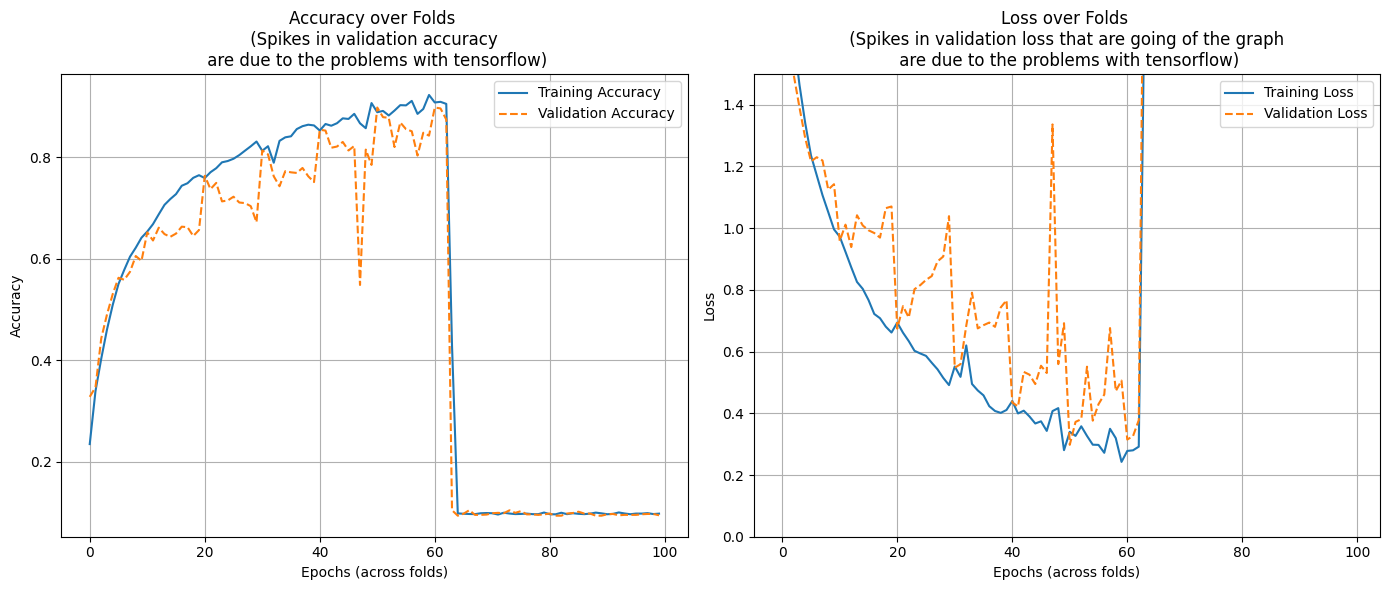

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


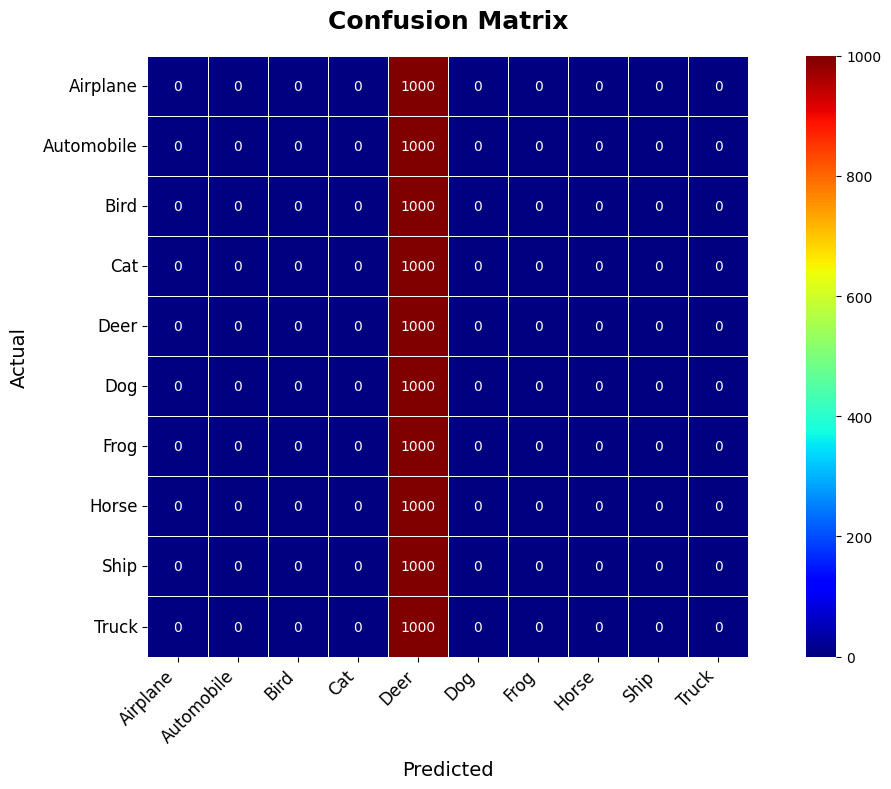

In [ ]:
# Accuracy and Loss over Folds
plot_acuracy_and_loss(all_histories)

# Confusion Matrix
plot_confusion_matrix(model_vgg)

todo: add explonation for the results

### **Inception v3**

### **Model Description**
Inception v3 is a neural network that is the successor of GoogleLeNet (Inception v1) and Inception v2. This version was introduced in 2015 and proposed in [*Rethinking the Inception Architecture for Computer Vision*](https://arxiv.org/pdf/1512.00567). The v3 provided improvements from its previous versions, such as adding a classifier to help and spread the information of the label through the network. [1]

This classifier are called Auxiliary Classifiers which provide a faster convergence deep down in the network as it attaches the the classifier head to the output of the layer. [2]

Sources:
- [1] https://paperswithcode.com/method/inception-v3
- [2] https://paperswithcode.com/method/auxiliary-classifier

### **Diagrams/Figures**

The image bellow can help us better understand the architecture of Inception v3. (This image was taken from https://paperswithcode.com/method/inception-v3)

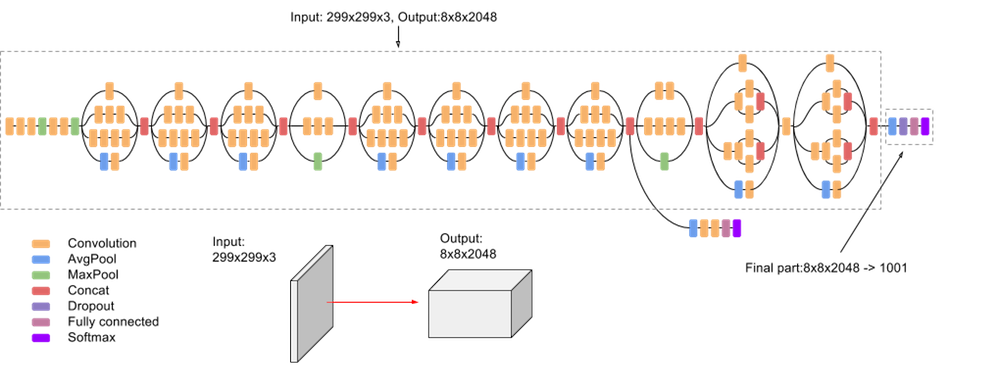

The figures (5, 6, 7, 8, 9) bellow were all taken from *Szegedy C. et al (2016)*

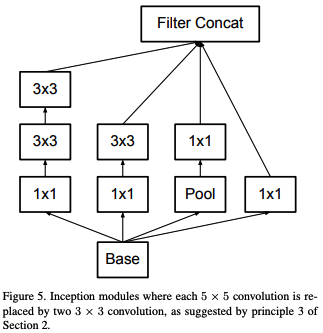

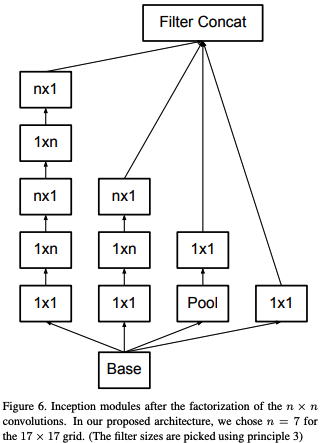

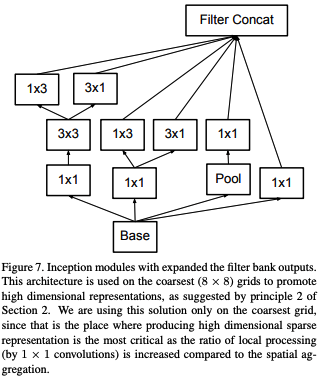

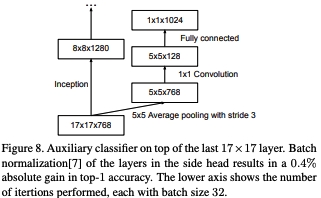

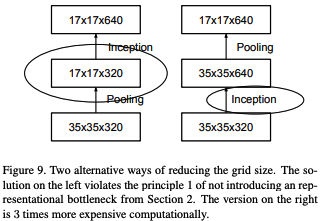

### **Architecture**

In the proposed architecture for the network, it contains; a total of 42 layers, an initial input size of 299x299 and 3 channels. Szegedy C. et al (2016)

The Layers are as follows:

| Layer | Patch Size | Stride | Input Size
| :- | :-: | :-: | :-: |
| Convolution | 3x3 | 2 | 299x200x3
| Convolution | 3x3 | 1 | 149x149x32
| Padded Convolution | 3x3 | 1 | 147x147x32
| Pooling | 3x3 | 2 | 147x147x64
| Convolution | 3x3 | 1 | 73x73x64
| Convolution | 3x3 | 2 | 71x71x80
| Convolution | 3x3 | 1 | 35x35x192
| 3 Inception Modules * | As in Figure 5 |  | 35x35x288
| 5 Inception Modules ** | As in Figure 6 |  | 17x17x765
| 2 Inception Modules *** | As in Figure 7 |  | 8x8x1280
| Pooling | 8x8 | 2 | 8x8x2048
| Linear | Logits |  | 1x1x2048
| Softimax | Classifier |  | 1x1x1000

The table above was taken from Szegedy C. et al (2016)

\* **Inception Module A (Figure 5.):** In this layer we have 3 inceptions modules where occurs the first feature extraction. In Figure 5. we can see that we have 2 convolution layers 3x3 on the left side, this two convolution layers comes from the Inception v1 model but in this case replaced each 5x5 layer with the 3x3 layers on the left.

\** **Inception Module B (Figure 6.):** Here we have 5 inception modules that balance the models efficiency with a deeper feature extraction. This inception module, in Szegedy et. al paper, is explained as converting a NxN convolution layer into multiple asymmetric convolution layers.

\*** **Inception Module C (Figure 7.):** Last 2 inception modules where it performs a high-level extraction on the features. In this layer the model performs a downsizing using an auxiliary classifier, we can see how this was implemented in Figure 8. and in Figure 9.

### **References/Sources**

*   Szegedy C. et al (2016) Rethinking the Inception Architecture for Computer Vision - https://arxiv.org/pdf/1512.00567

*   https://paperswithcode.com/method/inception-v3

*   https://paperswithcode.com/method/auxiliary-classifier


#### Pre-Trained Models

We will be creating two pre-trained models for the Inception v3. A frozen model where we are going to train it with no trainable weights and another unfrozen model with around 21,788,842 trainable weights. This will highlight the importance of trainable weights and how they affect the accuracy of the model.

Pre-trained model from Keras API: https://keras.io/api/applications/inceptionv3/

In [ ]:
# Download the pre-trained model and initialising the InceptionV3 model from Keras applications
inceptionV3 = InceptionV3(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

# Flatten the output and store the output layer into prediction
x = Flatten()(inceptionV3.output)
prediction = Dense(NUM_CLASSES, activation='softmax')(x)

# Creates the final model the inputs from pre-trained model with a custon classification layer
unfrozen_model_v3 = Model(inputs=inceptionV3.input, outputs=prediction)

# Copying the model before compiling so we can freeze the layers when training
frozen_model_v3 = tf.keras.models.clone_model(unfrozen_model_v3)
frozen_model_v3.set_weights(unfrozen_model_v3.get_weights())

# Freeze the layers of the pre-trained model
for layer in frozen_model_v3.layers:
    layer.trainable = False

##### Frozen Model

Here we are printing the summary of the model, to verify that it froze the layers.

In [ ]:
# Printing frozen model summary
frozen_model_v3.summary()

# Compile the model with the categorical_crossentropy loss function and Adam optimizer.
frozen_model_v3.compile(loss=LOSS, metrics=['accuracy'], optimizer=OPTIMIZER)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_961          │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 37, 37, 32)     │            864 │ keras_tensor_961[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 37, 37, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 37, 37, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 35, 35, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 35, 35, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 35, 35, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 35, 35, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 35, 35, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 35, 35, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 17, 17, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 17, 17, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 17, 17, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,823,274 (83.25 MB)

###### Train Model

Training the Frozen Model with KFold cross validation. Which will run a set of epochs in k folds.

In [ ]:
# Training the model

skf = KFold(n_splits=KFOLD_SPLIT)
all_histories = []
kFoldIndex = 1

for train_index, val_index in skf.split(x_train):
    print(f"Current KFold {kFoldIndex}")
    kFoldIndex += 1
    # Split the dataset for this fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train model for this fold
    history = frozen_model_v3.fit(x_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_fold, y_val_fold))
    all_histories.append(history.history)

    # Evaluate the model
    val_loss, val_acc = frozen_model_v3.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for this fold: {val_acc * 100:.4f}%")

Current KFold 1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.1003 - loss: 2.7017 - val_accuracy: 0.1004 - val_loss: 2.6805
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1016 - loss: 2.6876 - val_accuracy: 0.1004 - val_loss: 2.6805
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1011 - loss: 2.6943 - val_accuracy: 0.1004 - val_loss: 2.6805
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1029 - loss: 2.6926 - val_accuracy: 0.1004 - val_loss: 2.6805
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1029 - loss: 2.6909 - val_accuracy: 0.1004 - val_loss: 2.6805
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1020 - loss: 2.6866 - val_accuracy: 0.1004 - val_loss: 2.6805
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1030 - loss: 2.6829 - val_accuracy: 0.1004 - val_loss: 2.6805
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1018 - loss: 2.6928 - val_accuracy: 0.10

###### Results

Plotting the results for the Frozen Model.

* Accuracy over Folds
* Loss over Folds
* Confusion Matrix

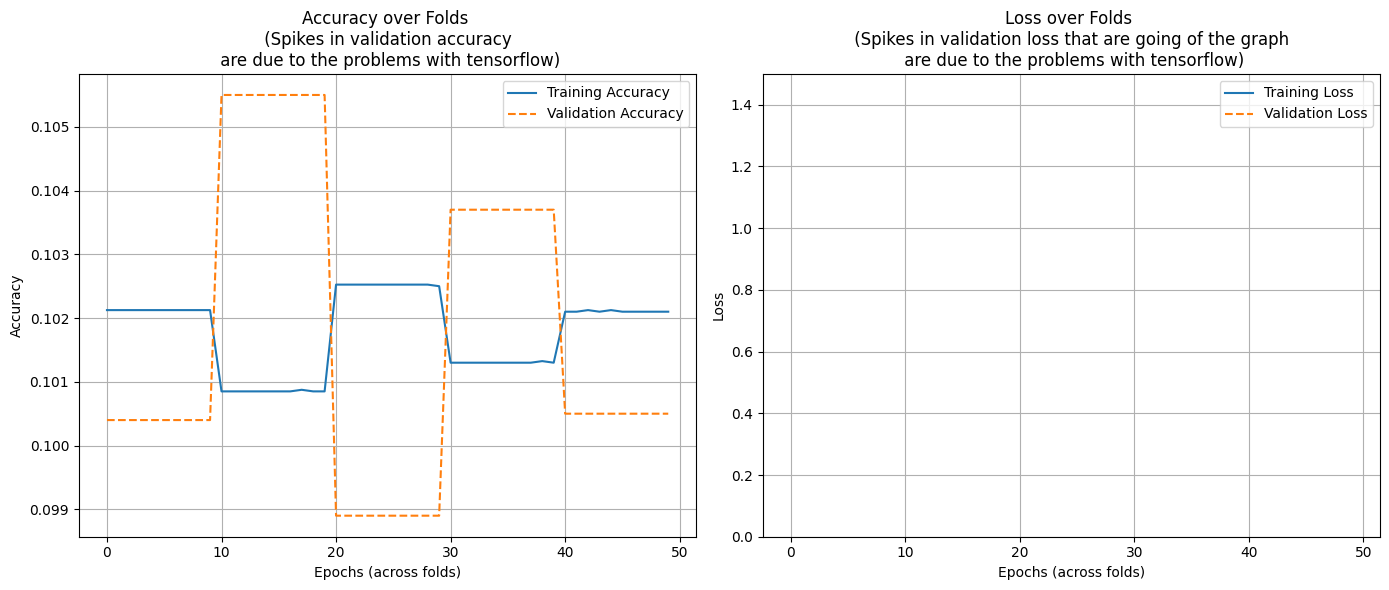

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step


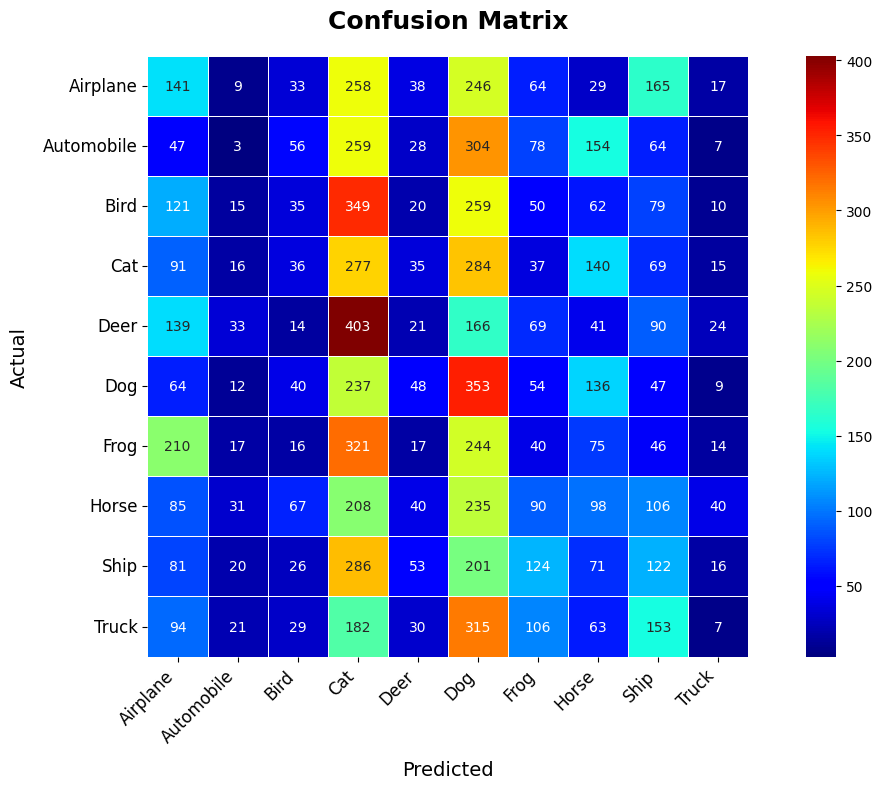

In [ ]:
# Accuracy and Loss over Folds
plot_acuracy_and_loss(all_histories)

# Confusion Matrix
plot_confusion_matrix(frozen_model_v3)

##### Unfrozen Model

Here we are printing the summary of the model, to verify it. We are also creating a new instance of the optimizer because the model was modified, if we do not create a new instance of the optimzer, the old one will not be aware of the new trainable layers.

In [ ]:
# Creating a new instance of the optimizer.
NEW_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Printing unfrozen model summary.
unfrozen_model_v3.summary()

# Compile the model with the categorical_crossentropy loss function and Adam optimizer.
unfrozen_model_v3.compile(loss=LOSS, metrics=['accuracy'], optimizer=NEW_OPTIMIZER)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 37, 37, 32)     │            864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 37, 37, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 37, 37, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 35, 35, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 35, 35, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 35, 35, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 35, 35, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 35, 35, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 35, 35, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 17, 17, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 17, 17, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 17, 17, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 21,788,842 (83.12 MB)

 Non-trainable params: 34,432 (134.50 KB)

###### Train Model

Just like with the other model now we are training the Unfrozen one with the same KFold cross validation.

In [ ]:
# Training the model

skf = KFold(n_splits=5)
all_histories = []
kFoldIndex = 1

for train_index, val_index in skf.split(x_train):
    print(f"Current KFold {kFoldIndex}")
    kFoldIndex += 1
    # Split the dataset for this fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train model for this fold
    history = unfrozen_model_v3.fit(x_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_fold, y_val_fold))
    all_histories.append(history.history)

    # Evaluate the model
    val_loss, val_acc = unfrozen_model_v3.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for this fold: {val_acc * 100:.4f}%")

Current KFold 1
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 114ms/step - accuracy: 0.3789 - loss: 1.7313 - val_accuracy: 0.3539 - val_loss: 55.3600
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6512 - loss: 1.0924 - val_accuracy: 0.1648 - val_loss: 43.5456
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6656 - loss: 1.0052 - val_accuracy: 0.6519 - val_loss: 1.0884
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7753 - loss: 0.6721 - val_accuracy: 0.6530 - val_loss: 1.0626
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8372 - loss: 0.4874 - val_accuracy: 0.7342 - val_loss: 0.8436
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8797 - loss: 0.3563 - val_accuracy: 0.4219 - val_loss: 2.3437
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7429 - loss: 0.8159 - val_accuracy: 0.6960 - val_loss: 0.9221
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.871

###### Results

Plotting the results for the Unfrozen Model.

* Accuracy over Folds
* Loss over Folds
* Confusion Matrix

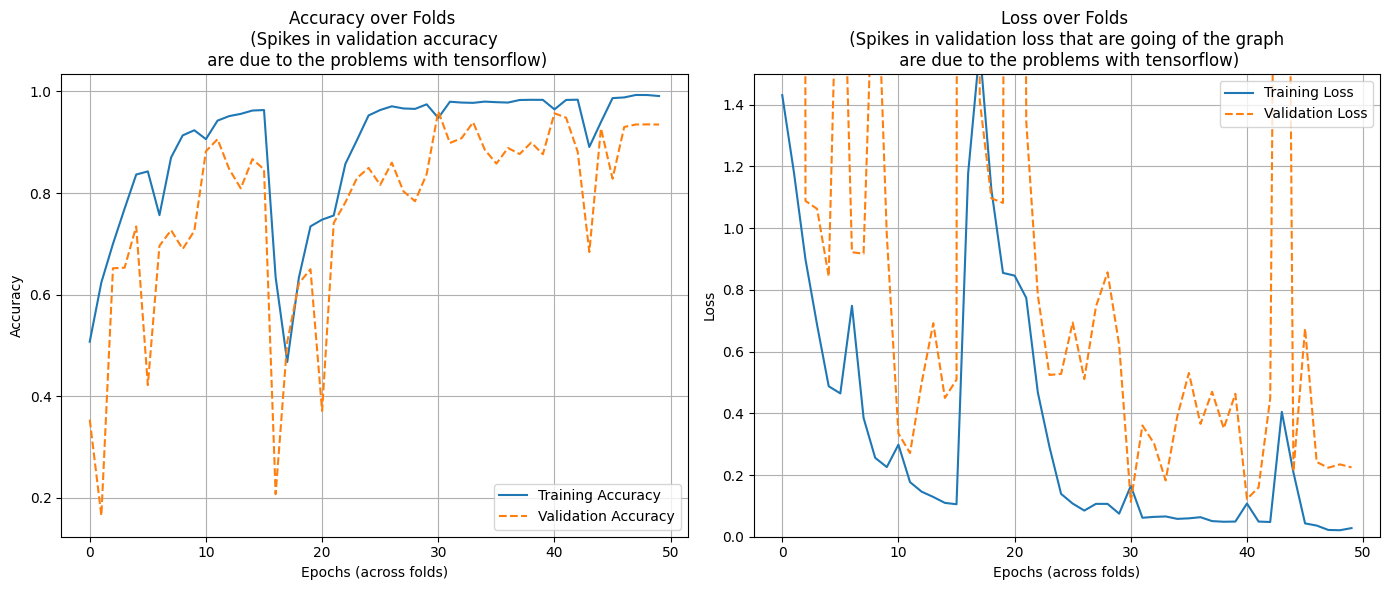

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step


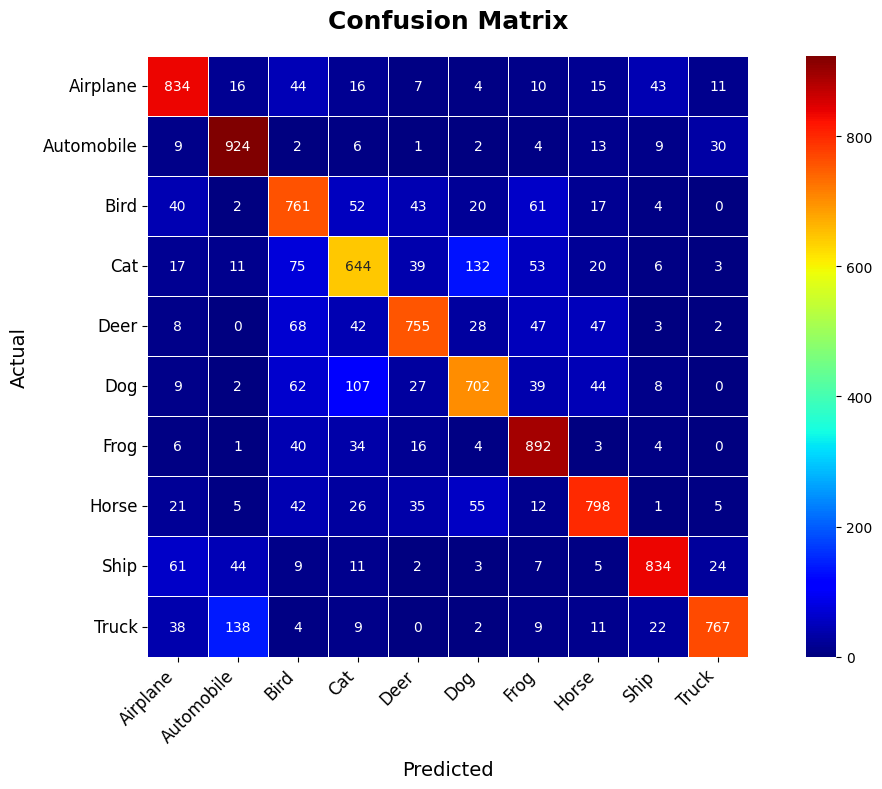

In [ ]:
# Accuracy and Loss over Folds
plot_acuracy_and_loss(all_histories)

# Confusion Matrix
plot_confusion_matrix(unfrozen_model_v3)

#### Frozen vs Unfrozen - Models Evaluation Inception v3

There is a very noticible difference in the results of both models. Since the Frozen model has no trainable layers, it cannot improve and learn after each epoch, unlike the Unfrozen model that is able to learn and perform really well. We can see this as the Unfrozen model performs with an accuracy of above 90%, and the Frozen model in the other hand can only have an accuracy that is between 10% and 15%.

We will be using the Unfrozen Model for comparing with the VGG19 CNN.

## **Reflection: VGG19 vs Inception v3**

After running both the VGG19 and the Inception v3 pre-trained models, with Frozen and Unfrozen layers, we came to the conclusion that the Unfrozen versions of the models are the best for comparison, as they are able to learn and improve on the weights. This is shown when we look at the outputted graphs for the models, we can see that the unfrozen models were able to better classify the dataset.

Due to architecture when we compare frozen models we can see that VGG19 is better then Inception v3.

When looking at the architecture of both VGG19 and Inception v3, we can say that the Inception model is slightly more efficient than VGG19.

The Inception v3 has branching implemented in its architecture which allows an extensive path between the modules of the network and it is also a small model as it is optimised with the factorised convolutions, VGG19 on the other hand is a fully sequential network and is much larger due to its fully connected dense layers.

\ ## **Numeric results from the models**

VGG19 - Unfrozen Model:
	Accuracy: val_acc is around 0.95
	Loss: val_loss is around 0.5

Inception v3 - Unfrozen Model:
	Accuracy: val_acc is around 0.92-0.93 // this is a good resulting acc
	Loss: val_loss is around 0.2-0.35 / this is good resulting loss

VGG19 - Frozen Model:
	Accuracy: val_acc is around 0.45-0.5
	Loss: val_loss is around 1.5

Inception v3 - Frozen Model:
	Accuracy: val_acc was around 0.11 - 0.12 (results are bad due to the fact that Inception v3 is trains on imagenet)
	Loss: val_loss is around 2.3-2.5


